### [ML-модели с помощью HYPEROPT](https://habr.com/ru/post/542624/)

In [1]:
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from hyperopt import hp, fmin, tpe, rand, Trials, STATUS_OK
import os

In [2]:
def f(args):
    x = args
    if x > 3:
        return (x-8.3)**2
    else:
        return (x+2)**2 + 3

TPE result {'x': 8.23531780044145}
random result {'x': -2.143085493189555}


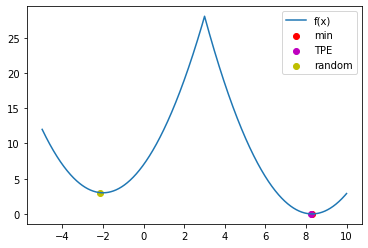

In [3]:
x = np.linspace(-5, 10, 1000)
y = list(map(f, x))
plt.plot(x, y, label='f(x)')
plt.scatter([8.3], [0], label='min', color='r')
space = hp.normal('x', -10, 10)

# метод байесовской оптимизации Tree of Parzen Estimators (TPE)
best = fmin(f, space, algo=tpe.suggest, max_evals=50,  show_progressbar=False)
print('TPE result', best)
plt.scatter(best['x'], f(best['x']), label='TPE', color='m')

best = fmin(f, space, algo=rand.suggest, max_evals=50,  show_progressbar=False)
print('random result', best)
plt.scatter(best['x'], f(best['x']), label='random', color='y')

plt.legend()
plt.show()

In [4]:
PATH_DIR = '../../bases'
FILE_NAME = 'adult.data'
PATH_FILE = os.path.join(PATH_DIR, FILE_NAME)
os.path.isfile(PATH_FILE)

True

In [5]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'per-week', 'native-country', 'salary']
df = pd.read_csv(PATH_FILE, header=None)
df.columns = cols
print(df.shape)

df.drop_duplicates(keep='first', inplace=True, ignore_index=True)
print(df.shape)

df.head()

(32561, 15)
(32537, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [18]:
X = df.drop(labels=['salary', 'native-country'], axis=1).copy()
y = df.loc[:, 'salary'].map({' <=50K': 0, ' >50K': 1}).values
# X = df.iloc[:1000, :]
# y = df.iloc[:1000, :]

#### Preprocessing
1. Categorical data - SimpleImputer (nan to '?', OHE);
2. Continuous - StandartScaler

In [19]:
nums = np.where(X.dtypes !=  'object')[0]
cats = np.where(X.dtypes == 'object')[0]
len(nums) + len(cats) == X.shape[1]

True

In [20]:
pipe_cat = Pipeline([
    ('imputer', SimpleImputer(missing_values='?', strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
    ])
pipe_num = Pipeline([
    ('scaler', StandardScaler())
    ])

In [21]:
trnsf = ColumnTransformer(
    transformers=[
        ('cat', pipe_cat, cats),
        ('num', pipe_num, nums),
        ],
        remainder='passthrough'
    )

model = Pipeline([
        ('transformer', trnsf),
        ('lr', LogisticRegression(random_state=32, n_jobs=-1,
                                solver='liblinear'))
    ])

#### Пространство поиска параметров для hyperopt

In [22]:
space = {
    'lr__penalty': hp.choice(label='penalty', options=['l1', 'l2']),
    'lr__C': hp.loguniform(label='C', low=-4*np.log(10), high=2*np.log(10))
    }

Зададим функцию, которую будем оптимизировать. Она принимает на вход гиперпараметры, модель и данные, после чего возвращает точность на кросс-валидации:

In [23]:
def objective(params, pipeline, X_train, y_train):
    """ Кросс-валидация с текущими гиперпараметрами"""
    
    pipeline.set_params(**params)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=32)
    
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train,
                           scoring='roc_auc', cv=skf, n_jobs=-1)
    
    return {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}

In [24]:
%%time
# история поиска
trials = Trials()

# fmin на вход принимает словарь значений гиперпараметров
best = fmin(
            # функция для оптимизации
            fn=partial(objective, pipeline=model, X_train=X, y_train=y),
            # пространство поиска гиперпараметров
            space=space, 
            # алгоритм поиска
            algo=tpe.suggest,     # algo=rand.suggest
            # число итераций (+ время поиска)
            max_evals=3,
            # объект для сохранения истории поиска
            trials=trials,
            rstate=np.random.RandomState(32),
            show_progressbar=True            
        )

100%|██████████| 3/3 [01:01<00:00, 20.40s/trial, best loss: -0.9068199363090965]
CPU times: user 370 ms, sys: 49 ms, total: 419 ms
Wall time: 1min 1s


In [18]:
trials.results

[{'loss': -0.9068199363090965,
  'params': {'lr__C': 4.690237297188879, 'lr__penalty': 'l1'},
  'status': 'ok'},
 {'loss': -0.9016471857875652,
  'params': {'lr__C': 0.016140304020745604, 'lr__penalty': 'l1'},
  'status': 'ok'},
 {'loss': -0.9040826111211661,
  'params': {'lr__C': 0.010162092251185204, 'lr__penalty': 'l2'},
  'status': 'ok'},
 {'loss': -0.9068032436501171,
  'params': {'lr__C': 38.02143741195047, 'lr__penalty': 'l1'},
  'status': 'ok'},
 {'loss': -0.9068127666907269,
  'params': {'lr__C': 10.39770166790649, 'lr__penalty': 'l2'},
  'status': 'ok'},
 {'loss': -0.9066094254692691,
  'params': {'lr__C': 0.07745474930245956, 'lr__penalty': 'l2'},
  'status': 'ok'},
 {'loss': -0.906817601066774,
  'params': {'lr__C': 17.16773963992117, 'lr__penalty': 'l2'},
  'status': 'ok'},
 {'loss': -0.9067699853241539,
  'params': {'lr__C': 0.6399608039674108, 'lr__penalty': 'l2'},
  'status': 'ok'},
 {'loss': -0.906537736440721,
  'params': {'lr__C': 0.06148111466793334, 'lr__penalty': 

In [15]:
def df_results(hp_results):
    """Отображаем результаты подбора в формате DataFrame"""
    
    results = pd.DataFrame([{**x, **x['params']} for x in hp_results])
    results.drop(labels=['status', 'params'], axis=1, inplace=True)
    results.loss = -results.loss
    results.sort_values(by=['loss'], ascending=False, inplace=True)
    
    return results

In [17]:
trials.results

[{'loss': -0.9068199363090965,
  'params': {'lr__C': 4.690237297188879, 'lr__penalty': 'l1'},
  'status': 'ok'},
 {'loss': -0.9016471857875652,
  'params': {'lr__C': 0.016140304020745604, 'lr__penalty': 'l1'},
  'status': 'ok'},
 {'loss': -0.9040826111211661,
  'params': {'lr__C': 0.010162092251185204, 'lr__penalty': 'l2'},
  'status': 'ok'},
 {'loss': -0.9068032436501171,
  'params': {'lr__C': 38.02143741195047, 'lr__penalty': 'l1'},
  'status': 'ok'},
 {'loss': -0.9068127666907269,
  'params': {'lr__C': 10.39770166790649, 'lr__penalty': 'l2'},
  'status': 'ok'},
 {'loss': -0.9066094254692691,
  'params': {'lr__C': 0.07745474930245956, 'lr__penalty': 'l2'},
  'status': 'ok'},
 {'loss': -0.906817601066774,
  'params': {'lr__C': 17.16773963992117, 'lr__penalty': 'l2'},
  'status': 'ok'},
 {'loss': -0.9067699853241539,
  'params': {'lr__C': 0.6399608039674108, 'lr__penalty': 'l2'},
  'status': 'ok'},
 {'loss': -0.906537736440721,
  'params': {'lr__C': 0.06148111466793334, 'lr__penalty': 

In [21]:
print(results)

        loss      lr__C lr__penalty
28  0.906826   7.889354          l1
36  0.906825   9.152218          l1
21  0.906825   8.319807          l1
20  0.906822   5.497113          l1
15  0.906822   5.359812          l1
30  0.906822  11.179855          l1
0   0.906820   4.690237          l1
6   0.906818  17.167740          l2
25  0.906818   3.525899          l1
37  0.906817  17.988509          l2
31  0.906815   2.685116          l1
4   0.906813  10.397702          l2
12  0.906813  74.426484          l2
10  0.906812  22.438243          l1
32  0.906805  34.609370          l1
14  0.906805   2.027526          l1
3   0.906803  38.021437          l1
29  0.906798  46.434357          l1
18  0.906789   1.127073          l1
16  0.906788   1.145066          l1
39  0.906786   1.117244          l2
22  0.906775  91.247721          l1
33  0.906773  96.510392          l1
7   0.906770   0.639961          l2
13  0.906753   0.605621          l1
19  0.906730   0.371976          l1
24  0.906632   0.248259     

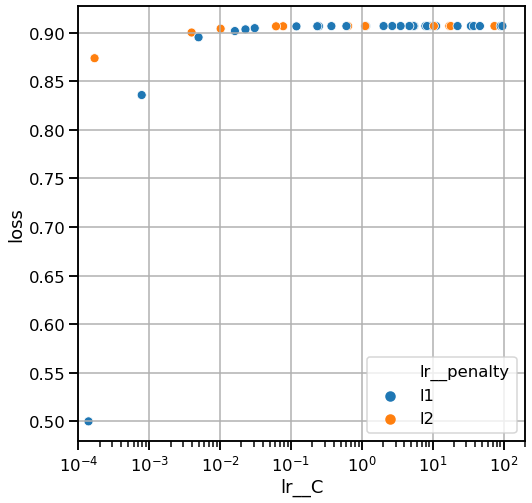

In [19]:
results = df_results(trials.results)
sns.set_context('talk')
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='lr__C', y='loss', hue='lr__penalty', data=results);
ax.set_xscale('log')
ax.set_xlim(1e-4, 2e2)
ax.grid()

На графике видно, что Hyperplot не исследовал районы, где получались низкие значения метрики, а сосредоточился на районе с наибольшими значениями.